In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

df = pd.read_csv('/content/drive/MyDrive/DL_Book_Notebooks/Chapter 7: Deep Unsupervised Learning I/Data/AMZN.csv')
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
date_min = df['Date'].min()
date_max = df['Date'].max()

print(date_min, date_max)

1997-05-15 00:00:00 2023-06-08 00:00:00


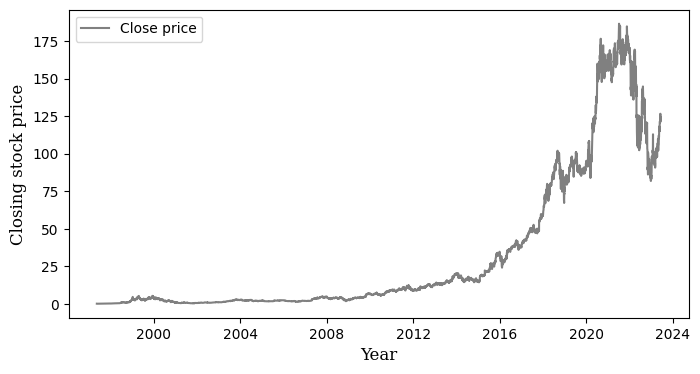

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(df['Date'], df['Close'], label='Close price',color='Grey')
plt.legend()
csfont = {'fontname':'serif'}
plt.xlabel('Year',fontsize=12,**csfont)
plt.ylabel('Closing stock price',fontsize=12,**csfont)
#plt.autoscale(axis='x',tight=True)
plt.savefig('stock.pdf')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

train_size = int(len(df) * 0.9)
test_size = len(df) - train_size

train, test = df.loc[0:train_size-1].copy(), df.loc[train_size:].copy()

print(train.shape)
print(test.shape)

scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close_scaled'] = scaler.transform(train[['Close']])
test['Close_scaled'] = scaler.transform(test[['Close']])


(5904, 2)
(656, 2)


In [ ]:
def create_dataset(X, y, time_steps=1):
  a, b = [], []
  for i in range(len(X) - time_steps):
     v = X.iloc[i:(i + time_steps)].values
     a.append(v)
     b.append(y.iloc[i + time_steps])
  return np.array(a), np.array(b)
# We’ll create sequences with 30 days of historical data
n_steps = 30
# reshape to 3D [n_samples, n_steps, n_features]
X_train, y_train = create_dataset(train[['Close_scaled']], train['Close_scaled'], n_steps)
X_test, y_test = create_dataset(test[['Close_scaled']], test['Close_scaled'], n_steps)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)


X_train shape: (5874, 30, 1)
X_test shape: (626, 30, 1)


In [ ]:
model = keras.Sequential()
# encoder block
model.add(keras.layers.LSTM(units=64,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
# decoder block
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed( keras.layers.Dense(units=X_train.shape[2])))

model.compile(loss='mae', optimizer='adam')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 30, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit( X_train, y_train, epochs=100, batch_size=32,
                    validation_split=0.1, shuffle=False)

Epoch 1/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 0.1464 - val_loss: 0.6148
Epoch 2/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.1069 - val_loss: 0.5119
Epoch 3/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0484 - val_loss: 0.4992
Epoch 4/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0430 - val_loss: 0.5153
Epoch 5/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0381 - val_loss: 0.4972
Epoch 6/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0414 - val_loss: 0.3790
Epoch 7/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0924 - val_loss: 0.2088
Epoch 8/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0719 - val_loss: 0.2713
Epoch 9/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0754 - val_loss: 0.2939
Epoch 10/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0841 - val_loss: 0.2103
Epoch 11/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0547 - val_loss: 0.3263
Epoch 12/100
166/166 ━━━━━

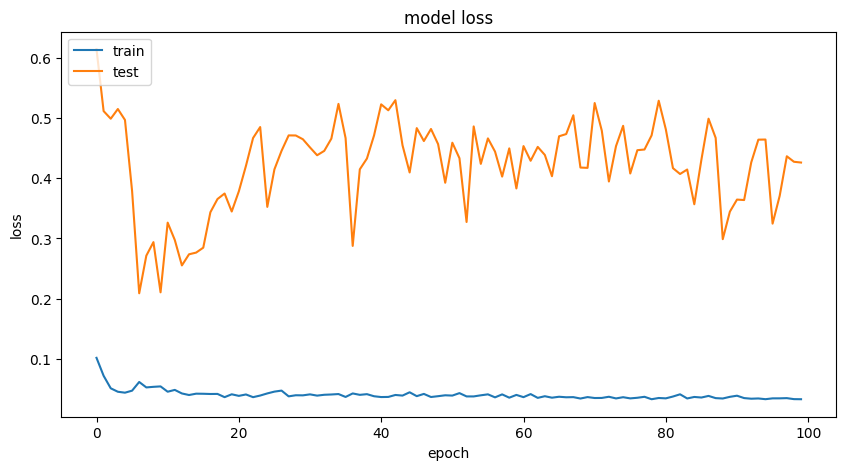

In [ ]:
# history for loss
plt.figure(figsize = (10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

Reconstruction error threshold: 1.8195955388555844


In [ ]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)
test_score_df = pd.DataFrame(test[n_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[n_steps:]['Close']

In [ ]:
print(test_score_df.head())

           Date       Close  Close_scaled      loss  threshold  anomaly
5934 2020-12-11  155.820999      4.170188  1.646415   1.819596    False
5935 2020-12-14  157.848495      4.232500  1.640985   1.819596    False
5936 2020-12-15  158.255997      4.245023  1.644492   1.819596    False
5937 2020-12-16  162.048004      4.361563  1.651981   1.819596    False
5938 2020-12-17  161.804001      4.354065  1.656542   1.819596    False


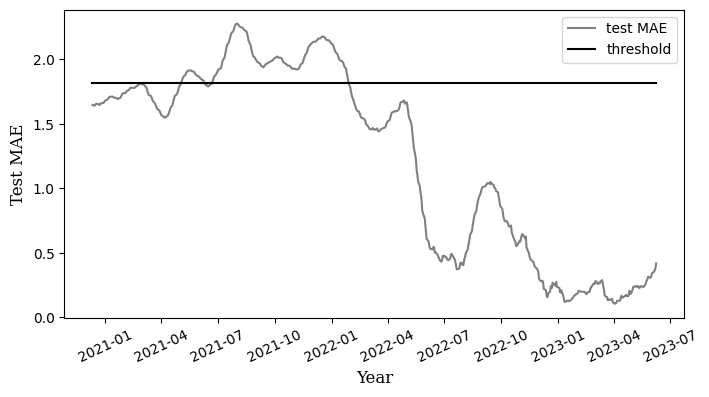

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(test_score_df['Date'], test_score_df.loss, label='test MAE',color='Grey')
plt.plot(test_score_df['Date'], test_score_df.threshold, label='threshold',color='Black')
plt.legend()
plt.xticks(rotation=25)
csfont = {'fontname':'serif'}
plt.xlabel('Year',fontsize=12,**csfont)
plt.ylabel('Test MAE',fontsize=12,**csfont)
#plt.autoscale(axis='x',tight=True)
plt.savefig('/content/drive/MyDrive/DL_Book_Notebooks/Chapter 7: Deep Unsupervised Learning I/Data/stock_thres.pdf')
plt.show()

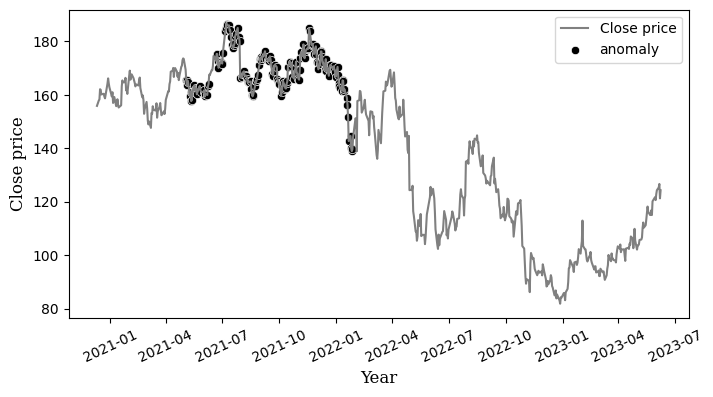

In [ ]:
import seaborn as sns
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies_close1 = anomalies[["Close"]].values
test_close1 = test_score_df[["Close"]].values

plt.figure(figsize=(8,4))
plt.plot(test_score_df['Date'],
         test_close1,
         label='Close price',color='Grey')

# convert it to a 1D array for the plot
anomalies_close = anomalies_close1.flatten()
sns.scatterplot(x=anomalies['Date'], y=anomalies_close,
                color='Black',
                label='anomaly'
               )

plt.xticks(rotation=25)
csfont = {'fontname':'serif'}
plt.xlabel('Year',fontsize=12,**csfont)
plt.ylabel('Close price',fontsize=12,**csfont)
plt.legend()
plt.savefig('/content/drive/MyDrive/DL_Book_Notebooks/Chapter 7: Deep Unsupervised Learning I/Data/stock_final.pdf')
plt.show()
